<a href="https://colab.research.google.com/github/Davidxdydz/Mandelbrot/blob/main/Mandelbrot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from numba.cuda import target
import numpy as np
import time
from numba import jit
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm.auto import tqdm
import tensorflow as tf

In [40]:
# tensorflow

def mandelbrotTensorflow(x,y,zoom,yRes,iterations,aspectRatio=1):
    factor = 1/zoom
    width = int(yRes*aspectRatio)
    height = int(yRes)
    x = np.linspace(x-factor*aspectRatio, x+factor*aspectRatio, width)
    y = np.linspace(y-factor, y+factor, height)

    X, Y = np.meshgrid(x, y)
    coords = 1j*Y+X

    xs = tf.constant(coords.astype(np.complex64))
    zs = tf.Variable(xs,np.complex64)
    not_diverged =tf.Variable(tf.zeros_like(xs, tf.bool))
    ns = tf.Variable(tf.zeros_like(xs, tf.float32))

    for i in range(iterations): 
      zs = zs*zs+xs
      not_diverged = tf.abs(zs) < 2
      ns = ns + tf.cast( not_diverged, tf.float32)
    n = ns.numpy()
    n[n == iterations] = 0
    return n

In [64]:
# numba
@jit(nopython=True)
def diverges(x, y, iterations):
    zr = x
    zi = y
    for i in range(iterations):
        zr, zi = zr*zr-zi*zi + x, 2 * zi*zr + y
        if (zr * zr + zi * zi) >= 4:
            return i
    return 0


@jit(nopython=True)
def mandelbrotNumba(x, y, zoom, yRes, iterations, aspectRatio=1):
    # this is actually way faster than numpy

    factor = 1/zoom
    width = int(yRes*aspectRatio)
    height = int(yRes)

    n = np.zeros((height, width), dtype=np.uint16)

    xs = np.linspace(x-factor*aspectRatio, x+factor*aspectRatio, width)
    ys = np.linspace(y-factor, y+factor, height)

    for xi, real in zip(range(width), xs):
        for yi, imag in zip(range(height), ys):
            n[yi, xi] = diverges(real, imag, iterations)

    return n

@jit(nopython=True)
def divergesJulia(x, y,cr,ci, iterations):
    zr = x
    zi = y
    for i in range(iterations):
        zr, zi = zr*zr-zi*zi + cr, 2 * zi*zr + ci
        if (zr * zr + zi * zi) >= 4:
            return i
    return 0


@jit(nopython=True)
def juliaNumba(x, y,cr,ci, zoom, yRes, iterations, aspectRatio=1):
    # this is actually way faster than numpy

    factor = 1/zoom
    width = int(yRes*aspectRatio)
    height = int(yRes)

    n = np.zeros((height, width), dtype=np.uint16)

    xs = np.linspace(x-factor*aspectRatio, x+factor*aspectRatio, width)
    ys = np.linspace(y-factor, y+factor, height)

    for xi, real in zip(range(width), xs):
        for yi, imag in zip(range(height), ys):
            n[yi, xi] = divergesJulia(real, imag,cr,ci, iterations)

    return n

In [73]:
# numpy

def mandelbrotNumpy(x, y, zoom, yRes, iterations, aspectRatio=1):
    # calculate window size
    factor = 1/zoom
    width = int(yRes*aspectRatio)
    height = int(yRes)
    x = np.linspace(x-factor*aspectRatio, x+factor*aspectRatio, width)
    y = np.linspace(y-factor, y+factor, height)

    # get 2D complex grid
    X, Y = np.meshgrid(x, y)
    coords = 1j*Y+X

    z = np.copy(coords)
    n = np.zeros((height, width))

    for i in range(iterations):
        mask = np.less(np.abs(z), 2)
        z[mask] = z[mask]**2+coords[mask]
        n[mask] = i
    n[n == iterations-1] = 0
    return n

In [74]:
# wrappers 

def plotCounts(count, cmaps=("hot",), title=None):
    sideLength = int(np.ceil(np.sqrt(len(cmaps))))
    (height, width) = count.shape
    aspectRatio = width/height
    fig, axes = plt.subplots(sideLength, sideLength, figsize=(
        aspectRatio*10, 10), squeeze=False, sharey=True, sharex=True)
    if title:
        fig.suptitle(title)
    for x in range(sideLength):
        for y in range(sideLength):
            index = y*sideLength + x
            if index >= len(cmaps):
                break
            axes[x, y].imshow(count, cmap=cmaps[index],interpolation='none')
            axes[x, y].set_title(f'cmap="{cmaps[index]}"')
    plt.show()


def plotMandelbrot(x, y, zoom, yRes, iterations, aspectRatio=1, cmaps=("hot",), backend = 'numba'):
    start = time.time()
    count = None
    if backend == 'numba':
        count = mandelbrotNumba(x, y, zoom, yRes, iterations, aspectRatio)
    elif backend == 'numpy':
        count = mandelbrotNumpy(x, y, zoom, yRes, iterations, aspectRatio)
    elif backend == 'tf':
        count = mandelbrotTensorflow(x, y, zoom, yRes, iterations, aspectRatio)
    end = time.time()
    title = f"x:{x}, y:{y}, zoom:{zoom:.2f}, {iterations} iterations ({end-start:.3f}s)"
    plotCounts(count, cmaps, title)


def animateZoom(x, y, zoomMin, zoomMax, yRes, iterations, aspectRatio=1, cmap="afmhot",speed = 0.1,fps = 2,duration = 5,backend = 'numba'):
    fig = plt.figure(figsize=(int(aspectRatio*10),10))
    #plt.tight_layout()
    dt = 1/fps * 1000 # in ms

    def getMandelbrot(zoom):
      if backend == 'numba':
        return mandelbrotNumba(x, y, zoom, yRes, iterations, aspectRatio)
      elif backend == 'numpy':
        return mandelbrotNumpy(x, y, zoom, yRes, iterations, aspectRatio)
      elif backend == 'tf':
        return mandelbrotTensorflow(x, y, zoom, yRes, iterations, aspectRatio)

    count = getMandelbrot(zoomMin)
    image = plt.imshow(count,cmap = cmap,animated = True)
    def update(zoom):
        count = getMandelbrot(zoom)
        image.set_array(count)
        return image,
    
    zooms = np.logspace(np.log(zoomMin)/np.log(1+speed),np.log(zoomMax)/np.log(1+speed),base = 1+speed,num = int(duration*fps))

    return FuncAnimation(fig,update,tqdm(zooms),interval = dt,blit=True)

In [6]:
# from matplotlib documentation
cmaps = dict()

cmaps['Perceptually Uniform Sequential'] = [
    'viridis', 'plasma', 'inferno', 'magma', 'cividis']

cmaps['Sequential'] = [
    'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
    'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
    'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

cmaps['Sequential (2)'] = [
    'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
    'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
    'hot', 'afmhot', 'gist_heat', 'copper']

cmaps['Diverging'] = [
    'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

cmaps['Cyclic'] = ['twilight', 'twilight_shifted', 'hsv']

cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']

cmaps['Miscellaneous'] = [
    'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']

goodCmaps = ['inferno', 'hot', 'afmhot', 'bone', 'gray', 'Spectral', 'seismic',
             'BrBG', 'PuOr', 'jet', 'cubehelix', 'terrain', 'brg']

In [7]:
# intersting coords
params = [
    # (x,y,zoom,y-Resolution,iterations,(optional: aspectRatio))
    (-0.745428, 0.113009, 33333, 1000, 500),
    (-0.5, 0, 0.9, 500, 150, 4/3)
]


7.278815031051636


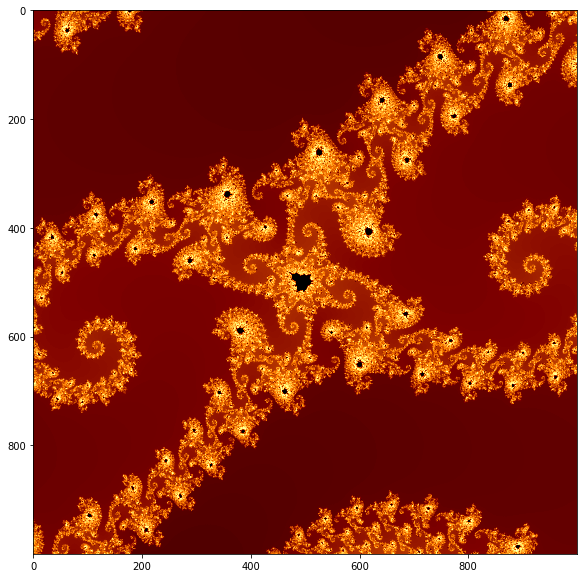

In [16]:
x,y,zoom,resolution,iterations = params[0]
start = time.time()
anim = animateZoom(x,y,1,zoom,1000,iterations,fps = 24,duration = 1,backend= 'tf')
vid = anim.to_html5_video()
end = time.time()
print()
print(end-start)

# 24 frames, 300*300
# numba: 6.3s
# numpy: 36.9s
# tf-cpu: 29.9s
# tf-gpu: 6.1s

# 5 frames, 1000*1000
# numba: 8.2s
# numpy: 42.1s
# tf-cpu: 56.1s
# tf-gpu: 1.6s

# 24 frames, 1000*1000
# tf-gpu: 7.3s

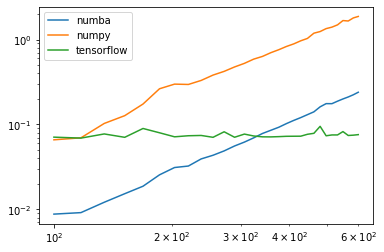

In [81]:
ress = np.linspace(100,600,30)
numbas = []
numpys = []
tfs = []
x,y,zoom,resolution,iterations = params[0]
for res in tqdm(ress):
  start = time.time()
  mandelbrotNumba(x,y,zoom,res,iterations)
  end = time.time()
  numbas.append(end-start)
  start = time.time()
  mandelbrotNumpy(x,y,zoom,res,iterations)
  end = time.time()
  numpys.append(end-start)
  start = time.time()
  mandelbrotTensorflow(x,y,zoom,res,iterations)
  end = time.time()
  tfs.append(end-start)

plt.plot(ress,numbas,label = "numba")
plt.plot(ress,numpys,label = "numpy")
plt.plot(ress,tfs,label = "tensorflow")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

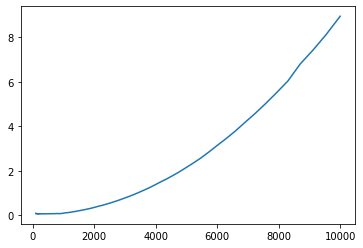

In [88]:
ress = np.logspace(2,4,base = 10,num=100)
tfs = []
x,y,zoom,resolution,iterations = params[0]
for res in tqdm(ress):
  start = time.time()
  mandelbrotTensorflow(x,y,zoom,res,iterations)
  end = time.time()
  tfs.append(end-start)

plt.plot(ress,tfs)
plt.show()